# install packages and import

In [ ]:
!pip install hazm
!pip install cleantext
!pip install transformers
!pip install numpy requests nlpaug

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# !pip Update hazm
# !pip update cleantext
# !pipx update transformers

In [ ]:
# Import required packages
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import hazm
from cleantext import clean
from transformers import BertConfig, BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, ConfusionMatrixDisplay, accuracy_score, roc_auc_score
from tqdm.notebook import tqdm
import os
import re
import json
import copy
import collections
from hazm import Normalizer, stopwords_list, word_tokenize

import matplotlib.pyplot as plt
import nlpaug.augmenter.word as naw
import plotly.express as px
import plotly.graph_objects as go
import string
from sklearn.preprocessing import LabelEncoder
from transformers import TFBertForSequenceClassification

# Dataset

In [ ]:
!unzip Snappfood-Dataset.zip

Archive:  Snappfood-Dataset.zip
   creating: Snappfood-Dataset/
  inflating: Snappfood-Dataset/dev.csv  
  inflating: Snappfood-Dataset/test.csv  
  inflating: Snappfood-Dataset/train.csv  


In [ ]:
def load_csv(file_path):
    data_df = pd.DataFrame(columns=['comment', 'label', 'label_id'])
    print(f'Loading {file_path}')
    with open(file_path) as f:
        for line in tqdm(f.readlines()[1:]):
            line = line.strip().replace('\t', ',').split(',')
            line = [part for part in line if len(part) != 0]
            if len(line) > 4:
                line[1:-2] = [' , '.join(line[1:-2])]

            data_df.loc[int(line[0])] = line[1:]

    print('Done.')
    return data_df


train_df = load_csv('Snappfood-Dataset/train.csv')
valid_df = load_csv('Snappfood-Dataset/dev.csv')
test_df = load_csv('Snappfood-Dataset/test.csv')

Loading Snappfood-Dataset/train.csv


  0%|          | 0/56700 [00:00<?, ?it/s]

Done.
Loading Snappfood-Dataset/dev.csv


  0%|          | 0/6300 [00:00<?, ?it/s]

Done.
Loading Snappfood-Dataset/test.csv


  0%|          | 0/7000 [00:00<?, ?it/s]

Done.


In [ ]:
# print data information
print('data information')
print(train_df.info(), '\n')

# print missing values information
print('missing values stats')
print(train_df.isnull().sum(), '\n')

# print some missing values
print('some missing values')
print(train_df[train_df['label'].isnull()].iloc[:5], '\n')

# print data information
print('data information')
print(valid_df.info(), '\n')

# print data information
print('data information')
print(test_df.info(), '\n')

data information
<class 'pandas.core.frame.DataFrame'>
Int64Index: 56700 entries, 0 to 56699
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   comment   56700 non-null  object
 1   label     56700 non-null  object
 2   label_id  56700 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB
None 

missing values stats
comment     0
label       0
label_id    0
dtype: int64 

some missing values
Empty DataFrame
Columns: [comment, label, label_id]
Index: [] 

data information
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6300 entries, 0 to 6299
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   comment   6300 non-null   object
 1   label     6300 non-null   object
 2   label_id  6300 non-null   object
dtypes: object(3)
memory usage: 196.9+ KB
None 

data information
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7000 entries, 0 to 6999
Data columns (total 3 c

In [ ]:
label_to_id = {'SAD': 1, 'HAPPY': 0}
id_to_label = {0: 'HAPPY', 1: 'SAD'}

In [ ]:
fig = go.Figure()

groupby_rate = train_df.groupby('label')['label'].count()

fig.add_trace(go.Bar(
    x=list(sorted(groupby_rate.index)),
    y=groupby_rate.tolist(),
    text=groupby_rate.tolist(),
    textposition='auto'
))

fig.update_layout(
    title_text='Distribution of rate within comments',
    xaxis_title_text='Rate',
    yaxis_title_text='Frequency',
    bargap=0.2,
    bargroupgap=0.2)

fig.show()

In [ ]:
minlim, maxlim = 2, 100

In [ ]:
# calculate the length of comments based on their words
train_df['comment_len_by_words'] = train_df['comment'].apply(lambda t: len(hazm.word_tokenize(t)))

In [ ]:
min_max_len = train_df["comment_len_by_words"].min(), train_df["comment_len_by_words"].max()
print(f'Min: {min_max_len[0]} \tMax: {min_max_len[1]}')

Min: 2 	Max: 378


In [ ]:
# remove comments with the length of fewer than three words
train_df['comment_len_by_words'] = train_df['comment_len_by_words'].apply(lambda len_t: len_t if minlim < len_t <= maxlim else None)
train_df = train_df.dropna(subset=['comment_len_by_words'])
train_df = train_df.reset_index(drop=True)

In [ ]:
fig = go.Figure()

groupby_rate = train_df.groupby('label')['label'].count()

fig.add_trace(go.Bar(
    x=list(sorted(groupby_rate.index)),
    y=groupby_rate.tolist(),
    text=groupby_rate.tolist(),
    textposition='auto'
))

fig.update_layout(
    title_text='Distribution of rate within comments',
    xaxis_title_text='Rate',
    yaxis_title_text='Frequency',
    bargap=0.2,
    bargroupgap=0.2)

fig.show()

# Data Augmentation

In [ ]:
# import persiannlpaug.augmenter.char as pna
import pandas as pd

# Define a function to augment text in a data frame
def augment_text(data):

    # Create a copy of the data frame
    augmented_df = data.copy()

    for i in range(0,len(data['comment']), 1):
      aug = naw.ContextualWordEmbsAug(model_path='HooshvareLab/bert-fa-base-uncased', action="substitute")
      sentence = data['comment'][i]
      augmented_text = aug.augment(sentence)
      new_data = {'comment': sentence, 'label': data['label'][i], 'label_id':data['label_id'][i]}
      augmented_df = augmented_df.append(new_data, ignore_index=True)

      aug = naw.ContextualWordEmbsAug(model_path='HooshvareLab/bert-fa-base-uncased', action="insert")
      sentence = data['comment'][i]
      augmented_text = aug.augment(sentence)
      new_data = {'comment': sentence, 'label': data['label'][i], 'label_id':data['label_id'][i]}
      augmented_df = augmented_df.append(new_data, ignore_index=True)

    return augmented_df

train_df = augment_text(train_df)
valid_df = augment_text(valid_df)

In [ ]:
fig = go.Figure()

groupby_rate = train_df.groupby('label')['label'].count()

fig.add_trace(go.Bar(
    x=list(sorted(groupby_rate.index)),
    y=groupby_rate.tolist(),
    text=groupby_rate.tolist(),
    textposition='auto'
))

fig.update_layout(
    title_text='Distribution of rate within comments',
    xaxis_title_text='Rate',
    yaxis_title_text='Frequency',
    bargap=0.2,
    bargroupgap=0.2)

fig.show()

In [ ]:
valid_df['label'].unique()

array(['SAD', 'HAPPY'], dtype=object)

# Preprocessing

In [ ]:
# cleaning comments
train_df['cleaned_comment'] = train_df['comment'].apply(cleaning)
valid_df['cleaned_comment'] = valid_df['comment'].apply(cleaning)
test_df['cleaned_comment'] = test_df['comment'].apply(cleaning)
# calculate the length of comments based on their words
train_df['cleaned_comment_len_by_words'] = train_df['cleaned_comment'].apply(lambda t: len(hazm.word_tokenize(t)))
valid_df['cleaned_comment_len_by_words'] = valid_df['cleaned_comment'].apply(lambda t: len(hazm.word_tokenize(t)))
test_df['cleaned_comment_len_by_words'] = test_df['cleaned_comment'].apply(lambda t: len(hazm.word_tokenize(t)))



valid_df['cleaned_comment_len_by_words'] = valid_df['cleaned_comment_len_by_words'].apply(lambda len_t: len_t if minlim < len_t <= maxlim else len_t)
valid_df = valid_df.dropna(subset=['cleaned_comment_len_by_words'])
valid_df = valid_df.reset_index(drop=True)

test_df['cleaned_comment_len_by_words'] = test_df['cleaned_comment_len_by_words'].apply(lambda len_t: len_t if minlim < len_t <= maxlim else len_t)
test_df = test_df.dropna(subset=['cleaned_comment_len_by_words'])
test_df = test_df.reset_index(drop=True)

In [ ]:
train_df = train_df[['cleaned_comment', 'label', 'label_id']]
train_df.columns = ['comment', 'label', 'label_id']
train_df.head()

,comment,label,label_id
0,واقعا حیف وقت که بنویسم سرویس دهیتون شده افتضاح,SAD,1
1,قرار بود ۱ ساعته برسه ولی نیم ساعت زودتر از مو...,HAPPY,0
2,قیمت این مدل اصلا با کیفیتش سازگاری نداره، فقط...,SAD,1
3,عالللی بود همه چه درست و به اندازه و کیفیت خوب...,HAPPY,0
4,شیرینی وانیلی فقط یک مدل بود.,HAPPY,0


In [ ]:
COMMENT_MAX_LEN=50

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# general config
MAX_LEN = 50
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
TEST_BATCH_SIZE = 16

EPOCHS = 3
EEVERY_EPOCH = 1000
LEARNING_RATE = 2e-5
CLIP = 0.0


MODEL_NAME_OR_PATH = 'HooshvareLab/bert-fa-base-uncased-sentiment-snappfood'
OUTPUT_PATH = '/content/bert-fa-base-uncased-sentiment-snappfood/pytorch_model.bin'

OUTPUT_MODEL_PATH = f'{OUTPUT_PATH}/pytorch_model.bin'

os.makedirs(OUTPUT_PATH, exist_ok=True)

In [ ]:
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME_OR_PATH)
config = BertConfig.from_pretrained(MODEL_NAME_OR_PATH)

In [ ]:
def cleanhtml(raw_html):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw_html)
    return cleantext


def cleaning(text):

        # import torch
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    text = text.strip()
    
    # regular cleaning
    text = clean(text,
    )

    # cleaning htmls
    text = cleanhtml(text)
    
    # normalizing
    normalizer = hazm.Normalizer()
    text = normalizer.normalize(text)
    
    # removing wierd patterns
    wierd_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u'\U00010000-\U0010ffff'
        u"\u200d"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\u3030"
        u"\ufe0f"
        u"\u2069"
        u"\u2066"
        # u"\u200c"
        u"\u2068"
        u"\u2067"
        "]+", flags=re.UNICODE)
    
    text = wierd_pattern.sub(r'', text)
    
    # removing extra spaces, hashtags
    text = re.sub("#", "", text)
    text = re.sub("\s+", " ", text)
    
    return text
    
# train_df = preprocess(train_df)
# valid_df = preprocess(valid_df)
# test_df = preprocess(test_df)

In [ ]:
test_df

,comment,label,label_id,cleaned_comment,cleaned_comment_len_by_words
0,خواهشا خواهشا خواهشا واسه ارسال شیرینیها یه فک...,HAPPY,0,خواهشا خواهشا خواهشا واسه ارسال شیرینیها یه فک...,33
1,غذا گرم رسید کیفیت و پخت گوشت عالی بود,HAPPY,0,غذا گرم رسید کیفیت و پخت گوشت عالی بود,9
2,قیمت سس شکلات روی بسته بندی ۱۵۰۰۰ بود ولی قیمت...,SAD,1,قیمت سس شکلات روی بسته بندی ۱۵۰۰۰ بود ولی قیمت...,27
3,عکس توی پیج یه شیرینی شکری روشن رنگ هست که همم...,SAD,1,عکس توی پیج یه شیرینی شکری روشن رنگ هست که همم...,51
4,باز هم میگم، پیتزا نباید اینقد چرب باشه,SAD,1,باز هم میگم، پیتزا نباید اینقد چرب باشه,9
...,...,...,...,...,...
6995,سطح پیتزا سوخته بود متاسفانه و ارزش اون پولو ن...,SAD,1,سطح پیتزا سوخته بود متاسفانه و ارزش اون پولو ن...,22
6996,بسته بندی خیلی بسیار بد شده,SAD,1,بسته بندی خیلی بسیار بد شده,6
6997,سلام خسته نباشید همه چی خوب بود فقط یک مقدار م...,HAPPY,0,سلام خسته نباشید همه چی خوب بود فقط یک مقدار م...,15
6998,غذا سرد و کیفیت قابل قبول نبود,SAD,1,غذا سرد و کیفیت قابل قبول نبود,7


# Dataloader

In [ ]:
class PrepareDataset(Dataset):
  
    def __init__(self, tokenizer, data, max_len=128):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, ind):
        item = self.data.iloc[ind]
        comment = item['comment']
        label = item['label_id']

        encoding = self.tokenizer.encode_plus(
            comment,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_len,
            return_token_type_ids=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt')
        
        return {
                'comment': comment,
                'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten(),
                'token_type_ids': encoding['token_type_ids'].flatten(),
                'lable': int(label),
                }

In [ ]:
train_dataset = PrepareDataset(tokenizer, train_df)
valid_dataset = PrepareDataset(tokenizer, valid_df)
test_dataset = PrepareDataset(tokenizer, test_df)

In [ ]:
test_dataset[0]

{'comment': 'خواهشا خواهشا خواهشا واسه ارسال شیرینیها یه فکری بکنید شانس اوردم سفارش من شیرینى خشک بود فکر کنم جعبه کاملا چپ شده بود واقعا جرات نمیکنم شیرینى\u200cتر و کیک سفارش بدم با این شرایط',
 'input_ids': tensor([    2, 18176,  2006, 18176,  2006, 18176,  2006, 29197,  4855, 32255,
          4642,  7182, 13067,  8586, 24883,  7785,  2842, 92924,  4990,  2834,
          4031,  5400,  9830,  4335,  6149,  2871,  2834,  5668, 12931, 12417,
         92924,  2838,  1379, 10585,  7785, 19910,  2799,  2802,  3517,     4,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]),
 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]),

In [ ]:
train_dataloder = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE)
valid_dataloder = DataLoader(valid_dataset, batch_size=VALID_BATCH_SIZE)
test_dataloder = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE)

In [ ]:
sample_data = next(iter(train_dataloder))

print(sample_data.keys())

print(sample_data['comment'])
print(sample_data['input_ids'].shape)
print(sample_data['input_ids'][0, :])
print(sample_data['attention_mask'].shape)
print(sample_data['attention_mask'][0, :])
print(sample_data['token_type_ids'].shape)
print(sample_data['token_type_ids'][0, :])
print(sample_data['lable'].shape)
print(sample_data['lable'][0])

dict_keys(['comment', 'input_ids', 'attention_mask', 'token_type_ids', 'lable'])
['واقعا حیف وقت که بنویسم سرویس دهیتون شده افتضاح', 'قرار بود ۱ ساعته برسه ولی نیم ساعت زودتر از موقع رسید، شما ببین چقدرررررررررررر پلاک خفنههههه، من سالهاست مشتریشونم و سالهاست مزه بهشت میده غذاشون', 'قیمت این مدل اصلا با کیفیتش سازگاری نداره، فقط ظاهر فریبنده داره، پرش میکنن کالباس و قارچ', 'عالللی بود همه چه درست و به اندازه و کیفیت خوب، امیداورم همیشه کیفیتتون خوب باشه ما مشتری همیشگی بشیم', 'شیرینی وانیلی فقط یک مدل بود.', 'بدترین پیتزایی که تا به حال خورده بودم', 'از همه لحاظ عالی ممنونم', 'کیفیت غذا متوسط رو به پایین بود انگار داخل یه رستوران معمولی غذا خوردی درحالی که امتیاز رستوران در اسنپ فود ۴٫۳ بود', 'همه اقلام تازه و به روز وخیلیییییی سریع بدستم رسید واقعا متشکرم', 'همه چی خوب ولی هات داگ دورش کلا سوخته بود و داخلش خام بود!!!!', 'اکلر فوق العاده بود اما بافت چیزکیک مونده بود و دوست نداشتم.', 'خوب بود و از رستوران غنچه و اسنپ فود تشکر میکنم', 'مثل همیشه عااااالی هستی پرپروک جاااااان مچکریم ازت

# Pretrained Bert features

In [ ]:
def auprc_score(y, yp):

  y_scores = yp
  y_pred = np.where(y_scores >= 0.5, 1, 0)
  precision, recall, thresholds = precision_recall_curve(y, y_pred)
  auprc = auc(recall, precision)

  return auprc

In [ ]:
bert = BertModel.from_pretrained('HooshvareLab/bert-fa-base-uncased-sentiment-snappfood')

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased-sentiment-snappfood were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
bert = bert.eval().to(device)

In [ ]:
bert

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(100000, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
 

In [ ]:
bert_outputs_train = torch.zeros(len(train_df), 768)
bert_outputs_valid = torch.zeros(len(valid_df), 768)
bert_outputs_test = torch.zeros(len(test_df), 768)

In [ ]:
def extractFeature(data, m):
  bert_outputs = torch.zeros(m, 768)
  i =0 
  for batch in data:
    with torch.no_grad():
      out = bert(batch["input_ids"].to(device), batch["attention_mask"].to(device), batch['token_type_ids'].to(device))['pooler_output'].to(device)
    bert_outputs[i: i + out.size(0)] = out
    i += out.size(0)
  return bert_outputs

In [ ]:
bert_outputs_train = extractFeature(train_dataloder, len(train_df))
bert_outputs_valid = extractFeature(valid_dataloder, len(valid_df))
bert_outputs_test = extractFeature(test_dataloder, len(test_df))

In [ ]:
y_train = train_df['label_id'].astype(int)
y_valid = valid_df['label_id'].astype(int)
y_test = test_df['label_id'].astype(int)

# Train classifier on Bert outputs

In [ ]:
clf = LogisticRegression()
clf.fit(bert_outputs_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression()

In [ ]:
h_train = clf.predict_proba(bert_outputs_train)
h_valid = clf.predict_proba(bert_outputs_valid)
h_test = clf.predict_proba(bert_outputs_test)

In [ ]:
print('Accuracy:')

print('Train: ', accuracy_score(y_train, h_train[:, 1] > 0.5))
print('Valid: ', accuracy_score(y_valid, h_valid[:, 1] > 0.5))
print('Test: ', accuracy_score(y_test, h_test[:, 1] > 0.5))

Accuracy:
Train:  0.952896560279289
Valid:  0.8553968253968254
Test:  0.8675714285714285


In [ ]:
print('F1-score:')

print('Train: ', f1_score(y_train, h_train[:, 1] > 0.5))
print('Valid: ', f1_score(y_valid, h_valid[:, 1] > 0.5))
print('Test: ', f1_score(y_test, h_test[:, 1] > 0.5))

F1-score:
Train:  0.9532881093810411
Valid:  0.8576784877362912
Test:  0.8687154793938536


In [ ]:
print('ROC AUC:')

print('Train: ', roc_auc_score(y_train, h_train[:, 1]))
print('Valid: ', roc_auc_score(y_valid, h_valid[:, 1]))
print('Test: ', roc_auc_score(y_test, h_test[:, 1]))

ROC AUC:
Train:  0.9883835908144709
Valid:  0.9274852103804486
Test:  0.9328837551020408


In [ ]:
th = 0.18
th

0.18


In [ ]:
print('Accuracy:')

print('Train: ', accuracy_score(y_train, h_train[:, 1] > th))
print('Valid: ', accuracy_score(y_valid, h_valid[:, 1] > th))
print('Test: ', accuracy_score(y_test, h_test[:, 1] > th))

Accuracy:
Train:  0.9398004572117173
Valid:  0.8633333333333333
Test:  0.8715714285714286


In [ ]:
print('F1-score:')

print('Train: ', f1_score(y_train, h_train[:, 1] > th))
print('Valid: ', f1_score(y_valid, h_valid[:, 1] > th))
print('Test: ', f1_score(y_test, h_test[:, 1] > th))

F1-score:
Train:  0.9423875990027645
Valid:  0.872046366473473
Test:  0.8787919644060941


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.metrics import Precision, Recall, AUC

# Define additional metrics
def f1_score(y_true, y_pred):
    tp = keras.backend.sum(keras.backend.round(keras.backend.clip(y_true * y_pred, 0, 1)))
    fp = keras.backend.sum(keras.backend.round(keras.backend.clip(y_pred - y_true, 0, 1)))
    fn = keras.backend.sum(keras.backend.round(keras.backend.clip(y_true - y_pred, 0, 1)))
    precision = tp / (tp + fp + keras.backend.epsilon())
    recall = tp / (tp + fn + keras.backend.epsilon())
    f1_score = 2 * precision * recall / (precision + recall + keras.backend.epsilon())
    return f1_score

# Define the neural network
model = keras.Sequential([
    keras.layers.Dense(64, input_dim=768, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(8, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy', Precision(), Recall(), AUC(name='auprc'), f1_score])
# Train the model
batch_size = 16
num_epochs = 5
history = model.fit(bert_outputs_train, y_train, batch_size=batch_size, epochs=num_epochs, verbose=1, validation_data=(bert_outputs_valid, y_valid))

Epoch 1/5
3527/3527 [==============================] - 19s 5ms/step - loss: 0.1487 - accuracy: 0.9461 - precision_2: 0.9364 - recall_2: 0.9570 - auprc: 0.9846 - f1_score: 0.9435 - val_loss: 0.3881 - val_accuracy: 0.8610 - val_precision_2: 0.8481 - val_recall_2: 0.8794 - val_auprc: 0.9331 - val_f1_score: 0.8544
Epoch 2/5
3527/3527 [==============================] - 15s 4ms/step - loss: 0.1421 - accuracy: 0.9485 - precision_2: 0.9402 - recall_2: 0.9577 - auprc: 0.9859 - f1_score: 0.9452 - val_loss: 0.3841 - val_accuracy: 0.8589 - val_precision_2: 0.8512 - val_recall_2: 0.8698 - val_auprc: 0.9329 - val_f1_score: 0.8510
Epoch 3/5
3527/3527 [==============================] - 15s 4ms/step - loss: 0.1402 - accuracy: 0.9496 - precision_2: 0.9407 - recall_2: 0.9594 - auprc: 0.9862 - f1_score: 0.9464 - val_loss: 0.4154 - val_accuracy: 0.8592 - val_precision_2: 0.8498 - val_recall_2: 0.8727 - val_auprc: 0.9320 - val_f1_score: 0.8522
Epoch 4/5
3527/3527 [==============================] - 16s 5ms/s

In [ ]:
# Evaluate the model on the test set
loss, accuracy, p, r , auprc, f1score = model.evaluate(bert_outputs_test, y_test)
print(f'Test Loss = {loss}, Test Accuracy = {accuracy}')
print(f'Percision = {p}, Recall = {r}')
print(f'AUPRC = {auprc}, F1-score = {f1score}')

219/219 [==============================] - 1s 4ms/step - loss: 0.3958 - accuracy: 0.8626 - precision_2: 0.8724 - recall_2: 0.8494 - auprc: 0.9374 - f1_score: 0.8579
Test Loss = 0.39580318331718445, Test Accuracy = 0.8625714182853699
Percision = 0.8723591566085815, Recall = 0.8494285941123962
AUPRC = 0.9373676776885986, F1-score = 0.8578528761863708


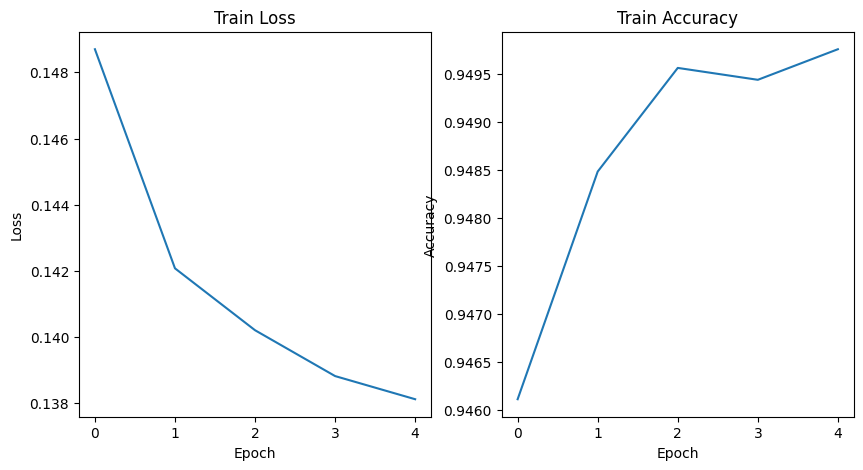

In [ ]:
# Plot the loss and accuracy over time
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(history.history['loss'])
axs[0].set_title('Train Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')

axs[1].plot(history.history['accuracy'])
axs[1].set_title('Train Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')

plt.show()

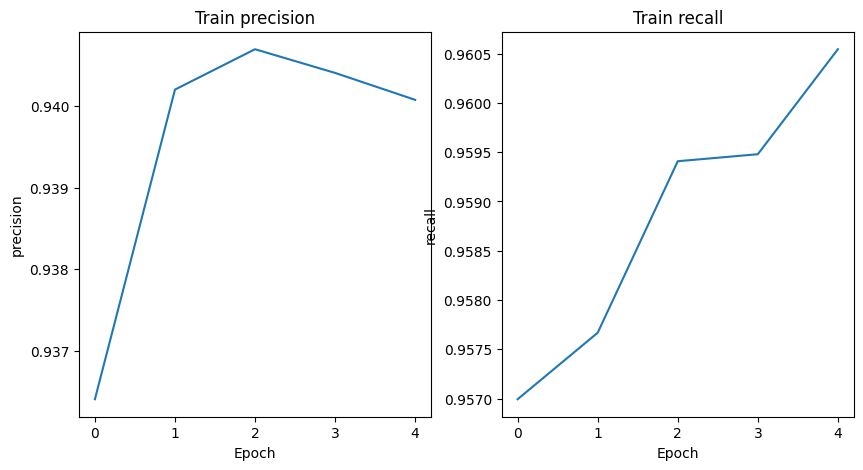

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))


axs[0].plot(history.history['precision_2'])
axs[0].set_title('Train precision')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('precision')

axs[1].plot(history.history['recall_2'])
axs[1].set_title('Train recall')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('recall')


plt.show()

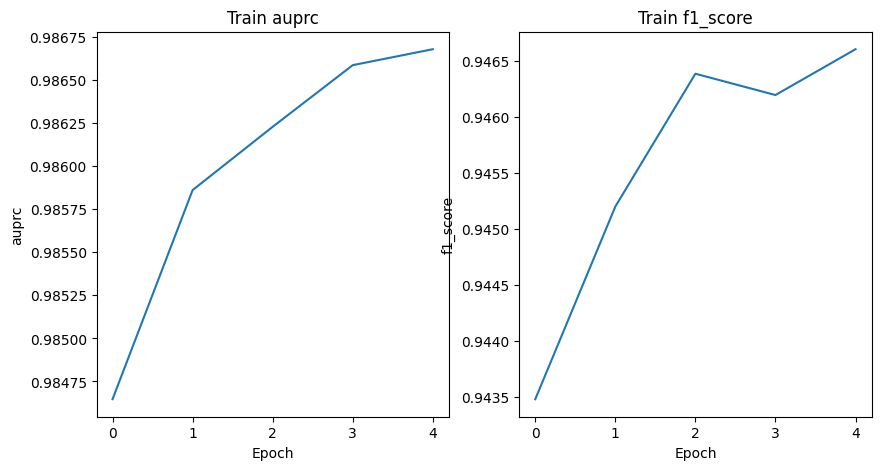

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))


axs[0].plot(history.history['auprc'])
axs[0].set_title('Train auprc')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('auprc')

axs[1].plot(history.history['f1_score'])
axs[1].set_title('Train f1_score')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('f1_score')

plt.show()

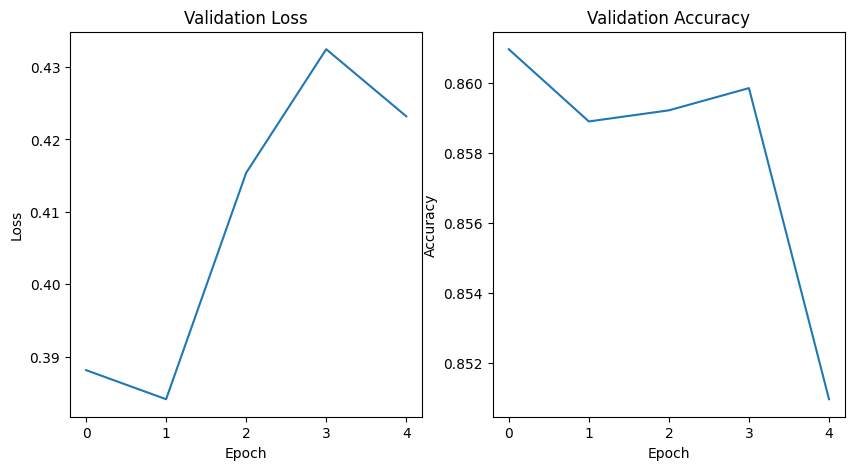

In [ ]:
# Plot the loss and accuracy over time
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(history.history['val_loss'])
axs[0].set_title('Validation Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')

axs[1].plot(history.history['val_accuracy'])
axs[1].set_title('Validation Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')

plt.show()

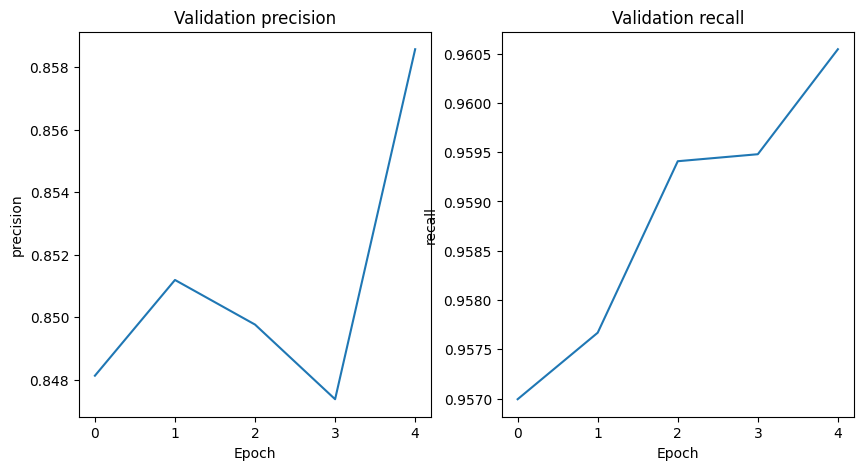

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))


axs[0].plot(history.history['val_precision_2'])
axs[0].set_title('Validation precision')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('precision')

axs[1].plot(history.history['recall_2'])
axs[1].set_title('Validation recall')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('recall')


plt.show()

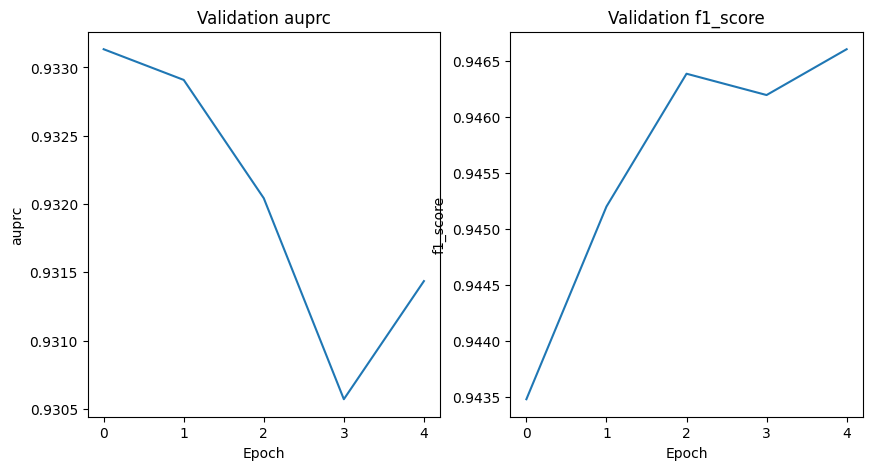

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))


axs[0].plot(history.history['val_auprc'])
axs[0].set_title('Validation auprc')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('auprc')

axs[1].plot(history.history['f1_score'])
axs[1].set_title('Validation f1_score')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('f1_score')

plt.show()

# Fine-Tuning model

In [ ]:
from transformers.pipelines import zero_shot_classification
class SentimentModel(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.bert = BertModel.from_pretrained(MODEL_NAME_OR_PATH)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, 1)
    
    def forward(self, input_ids, attention_mask, token_type_ids):
        z = self.bert(
            input_ids=input_ids, 
            attention_mask=attention_mask, 
            token_type_ids=token_type_ids)
        
        pooled_output = self.dropout(z['pooler_output'])
        out = self.classifier(pooled_output)
        return out 

In [ ]:
sf_model = SentimentModel(config=config)
sf_model = sf_model.to(device)

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased-sentiment-snappfood were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
sf_model

SentimentModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(100000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_a

# Train model

In [ ]:
def score_model(y_true, y_pred):
    # y_pred after sigmoid
    return {'acc': accuracy_score(y_true, y_pred > 0),
            'f1-score': f1_score(y_true, y_pred > 0),
            'auprc': auprc_score(y_true, y_pred)
    }

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, epochs, valid_steps=1000):
    train_history = {'loss': [], 'accuracy': [], 'f1-score': [], 'auprc': []}
    valid_history = {'loss': [], 'accuracy': [], 'f1-score': [], 'auprc': []}
     
    for e in range(epochs):
        sum_loss_train = 0
        sum_acc_train = 0
        sum_f1_train = 0
        sum_roc_train = 0
        train_steps = 0
        model.train()
        for batch in tqdm(dataloaders['train']):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            label = batch['lable'].to(device).view(-1, 1).float()

            optimizer.zero_grad()
            output = model(input_ids, attention_mask, token_type_ids)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()

            sum_loss_train += loss.item()
            output = nn.functional.sigmoid(output.detach())
            metrics = score_model(label.cpu().numpy(), output.cpu().numpy())
            sum_acc_train += metrics['acc']
            sum_f1_train += metrics['f1-score']
            sum_roc_train += metrics['auprc']
            train_steps += 1

            if train_steps % valid_steps == 0:
                print('Validation...')
                sum_loss_valid = 0
                sum_acc_valid = 0
                sum_f1_valid = 0
                sum_roc_valid = 0
                validation_steps = 0
                model.eval()
                for batch in tqdm(dataloaders['valid']):
                    input_ids = batch['input_ids'].to(device)
                    attention_mask = batch['attention_mask'].to(device)
                    token_type_ids = batch['token_type_ids'].to(device)
                    label = batch['lable'].to(device).view(-1, 1).float()

                    with torch.no_grad():
                        output = model(input_ids, attention_mask, token_type_ids)
                        loss = criterion(output, label)
                        
                        sum_loss_valid += loss.item()
                        output = nn.functional.sigmoid(output)
                        metrics = score_model(label.cpu().numpy(), output.cpu().numpy())
                        sum_acc_valid += metrics['acc']
                        sum_f1_valid += metrics['f1-score']
                        sum_roc_valid += metrics['auprc']
                        validation_steps += 1

                train_history['loss'].append(sum_loss_train / train_steps)
                train_history['accuracy'].append(sum_acc_train / train_steps)
                train_history['f1-score'].append(sum_f1_train / train_steps)
                train_history['auprc'].append(sum_roc_train / train_steps)

                valid_history['loss'].append(sum_loss_valid / validation_steps)
                valid_history['accuracy'].append(sum_acc_valid / validation_steps)
                valid_history['f1-score'].append(sum_f1_valid / validation_steps)
                valid_history['auprc'].append(sum_roc_valid / validation_steps)
                
                sum_loss_train = 0
                sum_acc_train = 0
                sum_f1_train = 0
                sum_roc_train = 0
                train_steps = 0

    return model, train_history, valid_history

In [ ]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Part1, training classifier

dataloders = {
    'train': train_dataloder,
    'valid': valid_dataloder
}

criterion = nn.BCEWithLogitsLoss()
sf_model.bert.requires_grad_ = False
optimizer = torch.optim.Adam(sf_model.classifier.parameters() ,lr=0.001)

sf_model, history_train, history_valid = train_model(sf_model, dataloders, criterion, optimizer, epochs=5)

  0%|          | 0/3527 [00:00<?, ?it/s]

Validation...


  0%|          | 0/394 [00:00<?, ?it/s]

Validation...


  0%|          | 0/394 [00:00<?, ?it/s]

Validation...


  0%|          | 0/394 [00:00<?, ?it/s]

  0%|          | 0/3527 [00:00<?, ?it/s]

Validation...


  0%|          | 0/394 [00:00<?, ?it/s]

Validation...


  0%|          | 0/394 [00:00<?, ?it/s]

Validation...


  0%|          | 0/394 [00:00<?, ?it/s]

  0%|          | 0/3527 [00:00<?, ?it/s]

Validation...


  0%|          | 0/394 [00:00<?, ?it/s]

Validation...


  0%|          | 0/394 [00:00<?, ?it/s]

Validation...


  0%|          | 0/394 [00:00<?, ?it/s]

  0%|          | 0/3527 [00:00<?, ?it/s]

Validation...


  0%|          | 0/394 [00:00<?, ?it/s]

Validation...


  0%|          | 0/394 [00:00<?, ?it/s]

Validation...


  0%|          | 0/394 [00:00<?, ?it/s]

  0%|          | 0/3527 [00:00<?, ?it/s]

Validation...


  0%|          | 0/394 [00:00<?, ?it/s]

Validation...


  0%|          | 0/394 [00:00<?, ?it/s]

Validation...


  0%|          | 0/394 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Loss')

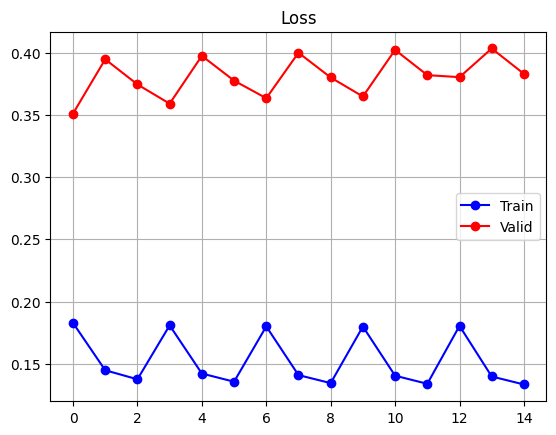

In [ ]:
plt.plot(history_train['loss'], 'bo-', label='Train')
plt.plot(history_valid['loss'], 'ro-', label='Valid')
plt.grid()
plt.legend()
plt.title('Loss')

Text(0.5, 1.0, 'Accuracy')

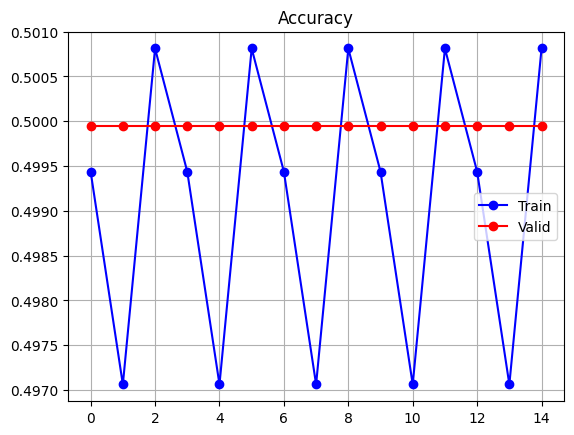

In [ ]:
plt.plot(history_train['accuracy'], 'bo-', label='Train')
plt.plot(history_valid['accuracy'], 'ro-', label='Valid')
plt.grid()
plt.legend()
plt.title('Accuracy')

Text(0.5, 1.0, 'F1-score')

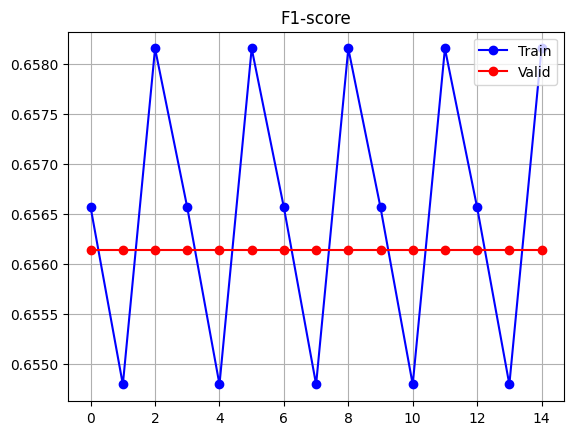

In [ ]:
plt.plot(history_train['f1-score'], 'bo-', label='Train')
plt.plot(history_valid['f1-score'], 'ro-', label='Valid')
plt.grid()
plt.legend()
plt.title('F1-score')

Text(0.5, 1.0, 'auprc')

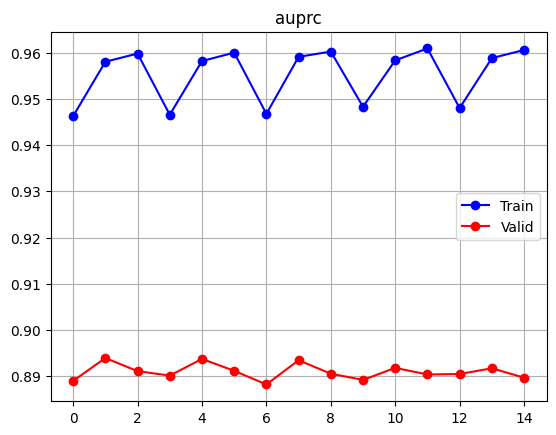

In [ ]:
plt.plot(history_train['auprc'], 'bo-', label='Train')
plt.plot(history_valid['auprc'], 'ro-', label='Valid')
plt.grid()
plt.legend()
plt.title('auprc')

In [ ]:
# Part2, finetuning

dataloders = {
    'train': train_dataloder,
    'valid': valid_dataloder
}

criterion = nn.BCEWithLogitsLoss()
sf_model.bert.requires_grad_ = True
optimizer = torch.optim.Adam(sf_model.parameters() ,lr=0.00001)

sf_model, history_train, history_valid = train_model(sf_model, dataloders, criterion, optimizer, epochs=5)

  0%|          | 0/3527 [00:00<?, ?it/s]

Validation...


  0%|          | 0/394 [00:00<?, ?it/s]

Validation...


  0%|          | 0/394 [00:00<?, ?it/s]

Validation...


  0%|          | 0/394 [00:00<?, ?it/s]

  0%|          | 0/3527 [00:00<?, ?it/s]

Validation...


  0%|          | 0/394 [00:00<?, ?it/s]

Validation...


  0%|          | 0/394 [00:00<?, ?it/s]

Validation...


  0%|          | 0/394 [00:00<?, ?it/s]

  0%|          | 0/3527 [00:00<?, ?it/s]

Validation...


  0%|          | 0/394 [00:00<?, ?it/s]

Validation...


  0%|          | 0/394 [00:00<?, ?it/s]

Validation...


  0%|          | 0/394 [00:00<?, ?it/s]

  0%|          | 0/3527 [00:00<?, ?it/s]

Validation...


  0%|          | 0/394 [00:00<?, ?it/s]

Validation...


  0%|          | 0/394 [00:00<?, ?it/s]

Validation...


  0%|          | 0/394 [00:00<?, ?it/s]

  0%|          | 0/3527 [00:00<?, ?it/s]

Validation...


  0%|          | 0/394 [00:00<?, ?it/s]

Validation...


  0%|          | 0/394 [00:00<?, ?it/s]

Validation...


  0%|          | 0/394 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Loss')

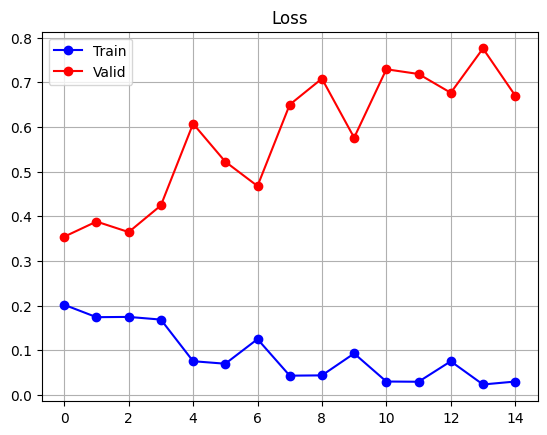

In [ ]:
plt.plot(history_train['loss'], 'bo-', label='Train')
plt.plot(history_valid['loss'], 'ro-', label='Valid')
plt.grid()
plt.legend()
plt.title('Loss')

Text(0.5, 1.0, 'Accuracy')

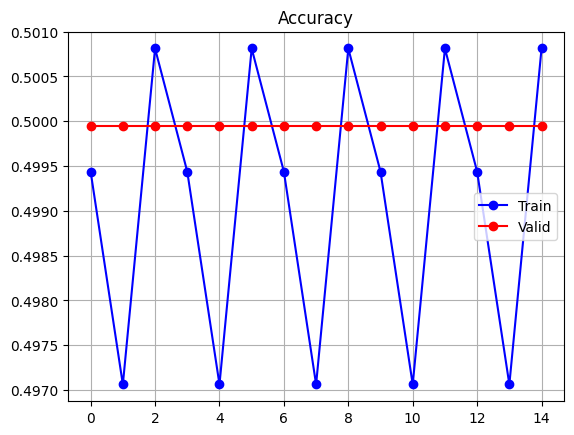

In [ ]:
plt.plot(history_train['accuracy'], 'bo-', label='Train')
plt.plot(history_valid['accuracy'], 'ro-', label='Valid')
plt.grid()
plt.legend()
plt.title('Accuracy')

Text(0.5, 1.0, 'F1-score')

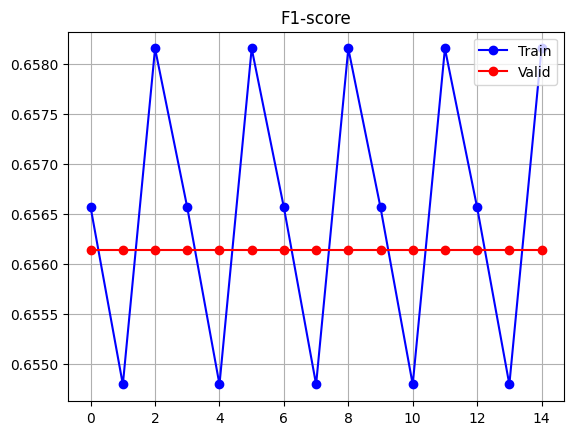

In [ ]:
plt.plot(history_train['f1-score'], 'bo-', label='Train')
plt.plot(history_valid['f1-score'], 'ro-', label='Valid')
plt.grid()
plt.legend()
plt.title('F1-score')

Text(0.5, 1.0, 'auprc')

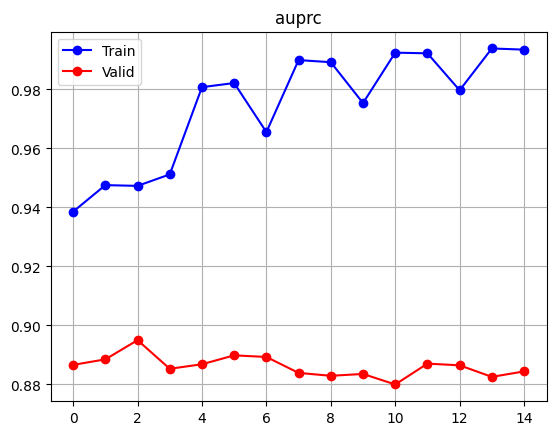

In [ ]:
plt.plot(history_train['auprc'], 'bo-', label='Train')
plt.plot(history_valid['auprc'], 'ro-', label='Valid')
plt.grid()
plt.legend()
plt.title('auprc')

# Final Test

In [ ]:
h_train = torch.zeros(len(train_df), 1)
h_valid = torch.zeros(len(valid_df), 1)
h_test = torch.zeros(len(test_df), 1)

In [ ]:
def extractFeature2(data, m):
  bert_outputs = torch.zeros(m, 1)
  i =0 
  for batch in data:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    token_type_ids = batch['token_type_ids'].to(device)
    with torch.no_grad():
        out = sf_model(input_ids, attention_mask, token_type_ids).cpu()
    h_train[i: i + out.size(0)] = out
    i += out.size(0)
  return bert_outputs

In [ ]:
h_train = extractFeature2(train_dataloder, len(train_df))
h_valid = extractFeature2(valid_dataloder, len(valid_df))
h_test = extractFeature2(test_dataloder, len(test_df))

In [ ]:
h_train = nn.functional.sigmoid(h_train)
h_valid = nn.functional.sigmoid(h_valid)
h_test = nn.functional.sigmoid(h_test)

In [ ]:
y_train = train_df['label_id'].astype(int)
y_valid = valid_df['label_id'].astype(int)
y_test = test_df['label_id'].astype(int)

In [ ]:
print('Accuracy:')

print('Train: ', accuracy_score(y_train, h_train > 0.5))
print('Valid: ', accuracy_score(y_valid, h_valid > 0.5))
print('Test: ', accuracy_score(y_test, h_test > 0.5))

Accuracy:
Train:  0.9940633362278262
Valid:  0.8539682539682539
Test:  0.8951428571428571


In [ ]:
print('F1-score:')

print('Train: ', f1_score(y_train, h_train > 0.5))
print('Valid: ', f1_score(y_valid, h_valid > 0.5))
print('Test: ', f1_score(y_test, h_test > 0.5))

F1-score:
Train:  0.9940572280073088
Valid:  0.8571872089413226
Test:  0.8999454743729551


In [ ]:
print('ROC AUC:')

print('Train: ', roc_auc_score(y_train, h_train))
print('Valid: ', roc_auc_score(y_valid, h_valid))
print('Test: ', roc_auc_score(y_test, h_test))

ROC AUC:
Train:  0.9997838283292696
Valid:  0.9177335852859663
Test:  0.9568244954812624
